In [1]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("d1shs0ap/cognitive-behaviors-Llama-3.2-3B")

In [7]:
def get_lengths(rollouts):
    correct_lengths_by_difficulty = defaultdict(list)
    incorrect_lengths_by_difficulty = defaultdict(list)

    for i in range(len(rollouts) // 8):
        difficulty = rollouts[i * 8]['ref_score']
        correct_length = 0
        incorrect_length = 0
        correct_count = 0
        incorrect_count = 0
        
        for j in range(8):
            row = rollouts[i * 8 + j]

            if row['score'] == 0:
                incorrect_length += row['length']
                incorrect_count += 1
            elif row['score'] == 1:
                correct_length += row['length']
                correct_count += 1
        
        correct_lengths_by_difficulty[difficulty].append(correct_length / correct_count if correct_count > 0 else 0)
        incorrect_lengths_by_difficulty[difficulty].append(incorrect_length / incorrect_count if incorrect_count > 0 else 0)
    
    return correct_lengths_by_difficulty, incorrect_lengths_by_difficulty

0.0 0.0
1944.83977702192 247.26475468975468
2550.5192829457355 273.47569444444446
2603.7829173838213 277.97425170068027
0.0 0.0
2198.832272432783 73.14669738863286
2239.1203765227024 153.4043650793651
2262.7767195767206 150.9468509984639


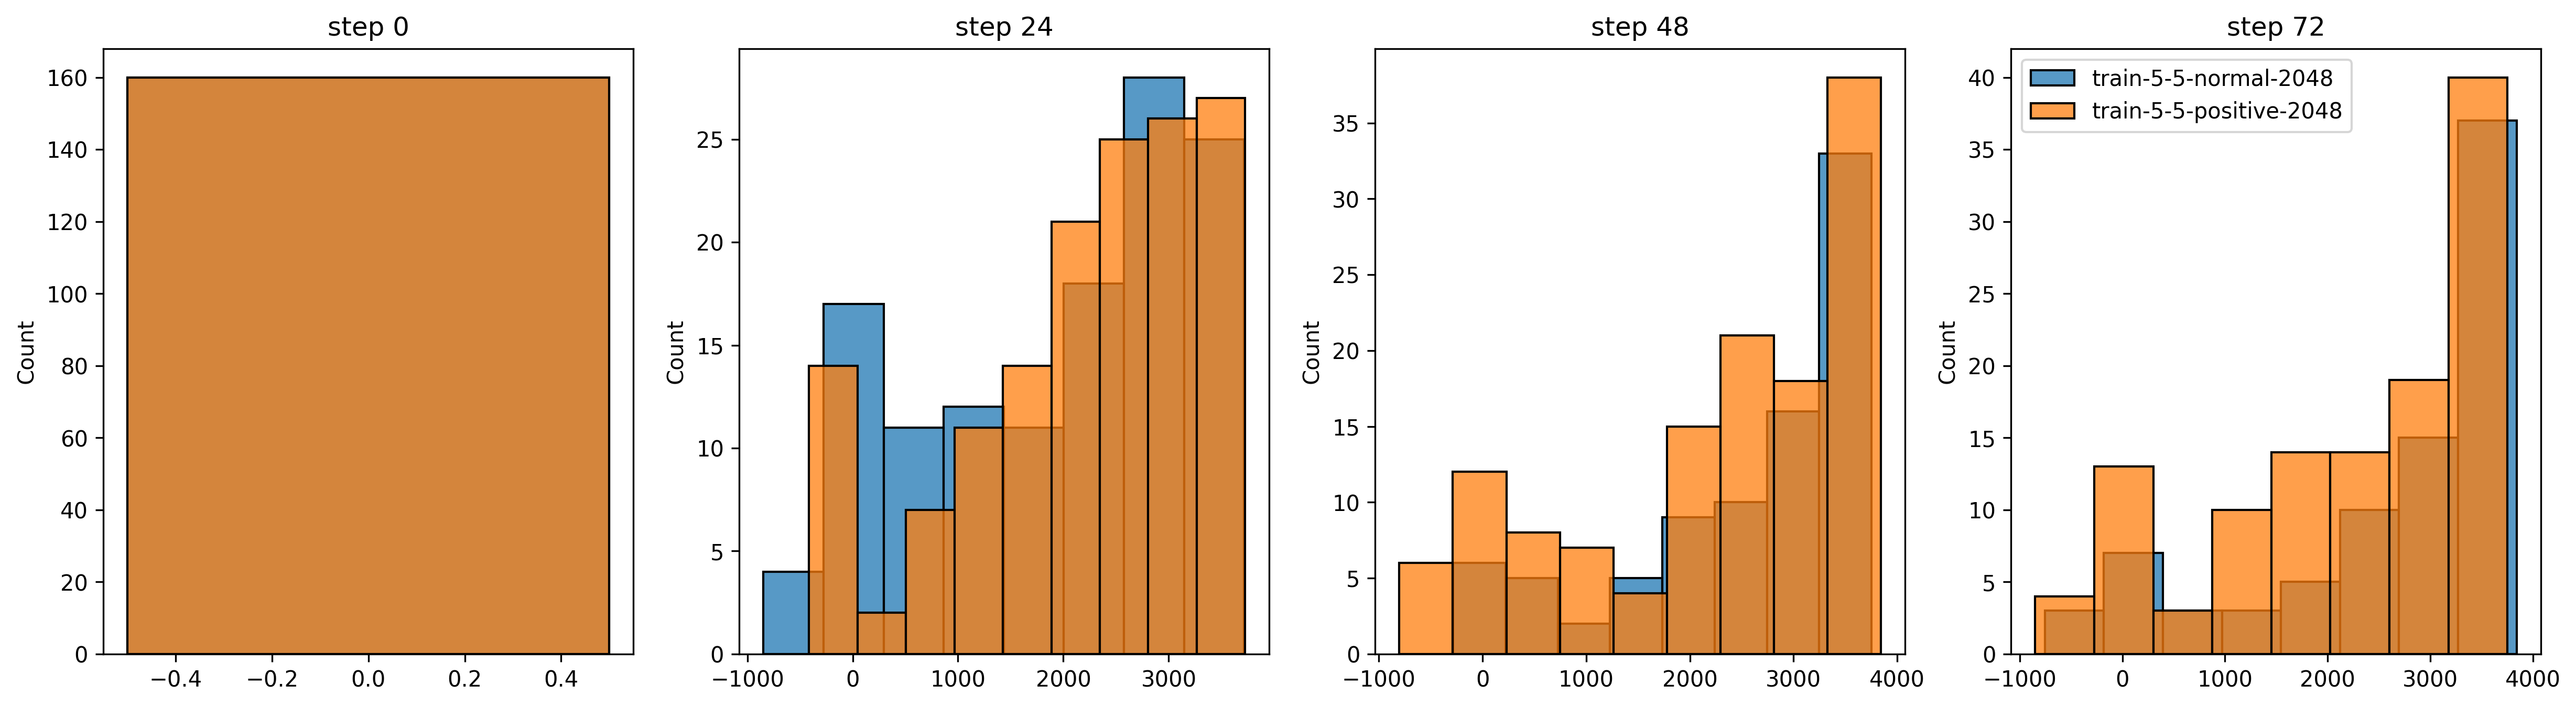

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), dpi=300)
for folder in ['train-5-5-normal-2048', 'train-5-5-positive-2048']:

    base_rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/{folder}/0_extrapolation_rollouts.json"
    with open(base_rollouts_file, 'r') as f:
        base_rollouts = json.load(f)
    
    base_correct_lengths_by_difficulty, base_incorrect_lengths_by_difficulty = get_lengths(base_rollouts)
    
    for i, step in enumerate(range(0, 72 + 1, 24)):
        rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/{folder}/{step}_extrapolation_rollouts.json"
        with open(rollouts_file, 'r') as f:
            rollouts = json.load(f)
        
        correct_lengths_by_difficulty, incorrect_lengths_by_difficulty = get_lengths(rollouts)
        for j, difficulty in enumerate(range(5, 6)):

            correct_diffs = []
            for base_length, length in zip(base_correct_lengths_by_difficulty[difficulty], correct_lengths_by_difficulty[difficulty]):
                if length == 0 or base_length == 0:
                    continue
                correct_diffs.append(length - base_length)

            incorrect_diffs = []
            for base_length, length in zip(base_incorrect_lengths_by_difficulty[difficulty], incorrect_lengths_by_difficulty[difficulty]):
                if length == 0 or base_length == 0:
                    continue
                incorrect_diffs.append(length - base_length)

            print(sum(incorrect_diffs) / len(incorrect_diffs), sum(correct_diffs) / len(correct_diffs))
            # sns.histplot(x=correct_diffs, ax=ax[i], label="correct")
            sns.histplot(x=incorrect_diffs, ax=ax[i], label=folder)
            # if i == 0:
            #     fig.text(0.19 + 0.133 * j, 0.9, f"difficulty {difficulty}", ha='center', fontsize=12)
            ax[i].set_title(f"step {step}")

    # plt.suptitle(folder, y=0.93)

plt.legend()
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
plt.clf()